# Load Loughran-McDonald sentiments

In [1]:
%pip install --user -U nltk
%pip install pandas spacy openpyxl matplotlib seaborn plotly statsmodels scikit-learn
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import os
import json
import csv
import nltk
import spacy
from collections import defaultdict
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import quantreg

In [3]:
def load_loughran_mcdonald_dictionary(filepath):
    # Load each sheet as a dictionary 
    sentiments = {}
    sheet_names = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']
    
    for sheet in sheet_names:
        words = pd.read_excel(filepath, sheet_name=sheet, header=None).squeeze().tolist()
        sentiments[sheet] = set(word.lower() for word in words) 
    
    return sentiments

dictionary_path = 'LoughranMcDonald_SentimentWordLists_2018.xlsx'
sentiment_dictionary = load_loughran_mcdonald_dictionary(dictionary_path)

# Calculate sentiment scores based on tokens

In [4]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer, stop words, and spaCy model
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

# All possible sentiment categories including modals and raw modal counts
sentiment_categories = ["negative", "positive", "uncertainty", "litigious", "constraining",
                        "strong_modal_positive", "strong_modal_negative", "strong_modal_uncertainty",
                        "strong_modal_litigious", "strong_modal_constraining",
                        "weak_modal_positive", "weak_modal_negative", "weak_modal_uncertainty",
                        "weak_modal_litigious", "weak_modal_constraining",
                        "strong_modal_raw_count", "weak_modal_raw_count"]

input_dir = '/Users/dulvin/Downloads/MarketAnalysis/Anjula/shared/transcipts'
output_dir = 'Sentiment_CSVs2'
os.makedirs(output_dir, exist_ok=True)

# preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens

# calculate sentiment scores based on tokens
def calculate_sentiment(tokens, sentiment_words):
    return sum(1 for token in tokens if token in sentiment_words)

# 
def parse_dependencies(raw_text):
    doc = nlp(raw_text)
    syntactic_sentiments = defaultdict(int)

    for token in doc:
        if token.lemma_ in sentiment_dictionary["StrongModal"]:
            modal_type = "strong_modal"
            syntactic_sentiments["strong_modal_raw_count"] += 1
        elif token.lemma_ in sentiment_dictionary["WeakModal"]:
            modal_type = "weak_modal"
            syntactic_sentiments["weak_modal_raw_count"] += 1
        else:
            continue

        for child in token.children:
            if child.dep_ in ("dobj", "ccomp", "xcomp", "advcl", "acomp", "neg", "amod", "npadvmod"):
                action = child.lemma_

                if action in sentiment_dictionary["Positive"]:
                    syntactic_sentiments[f"{modal_type}_positive"] += 1
                elif action in sentiment_dictionary["Negative"]:
                    syntactic_sentiments[f"{modal_type}_negative"] += 1
                elif action in sentiment_dictionary["Uncertainty"]:
                    syntactic_sentiments[f"{modal_type}_uncertainty"] += 1
                elif action in sentiment_dictionary["Litigious"]:
                    syntactic_sentiments[f"{modal_type}_litigious"] += 1
                elif action in sentiment_dictionary["Constraining"]:
                    syntactic_sentiments[f"{modal_type}_constraining"] += 1

    return syntactic_sentiments

for file_name in os.listdir(input_dir):
    if file_name.endswith('.json'):
        file_path = os.path.join(input_dir, file_name)
        company_name = os.path.splitext(file_name)[0]
        output_file = os.path.join(output_dir, f"{company_name}_sentiments.csv")

        with open(file_path, 'r') as file:
            data = json.load(file)
        year_quarter_sentiments = defaultdict(lambda: defaultdict(lambda: {'sentiments': defaultdict(int), 'dates': []}))

        for entry in data:
            year = entry['year']
            quarter = entry['quarter']
            date = entry['time']
            transcript = ' '.join([speech for segment in entry['transcript'] for speech in segment['speech']])

            for category in sentiment_categories:
                year_quarter_sentiments[year][quarter]['sentiments'][category] = 0

            tokens = preprocess_text(transcript)

            year_quarter_sentiments[year][quarter]['sentiments']['negative'] += calculate_sentiment(tokens, sentiment_dictionary["Negative"])
            year_quarter_sentiments[year][quarter]['sentiments']['positive'] += calculate_sentiment(tokens, sentiment_dictionary["Positive"])
            year_quarter_sentiments[year][quarter]['sentiments']['uncertainty'] += calculate_sentiment(tokens, sentiment_dictionary["Uncertainty"])
            year_quarter_sentiments[year][quarter]['sentiments']['litigious'] += calculate_sentiment(tokens, sentiment_dictionary["Litigious"])
            year_quarter_sentiments[year][quarter]['sentiments']['constraining'] += calculate_sentiment(tokens, sentiment_dictionary["Constraining"])

            syntactic_sentiments = parse_dependencies(transcript)
            for sentiment, count in syntactic_sentiments.items():
                year_quarter_sentiments[year][quarter]['sentiments'][sentiment] += count

            year_quarter_sentiments[year][quarter]['dates'].append(date)

        # Write sentiment data to CSV
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            header = ['ID', 'Year', 'Quarter', 'Date'] + sentiment_categories
            writer.writerow(header)

            for year, quarters in year_quarter_sentiments.items():
                for quarter, data in quarters.items():
                    unique_id = f"{year}_Q{quarter}"
                    earliest_date = min(data['dates'])  
                    row = [unique_id, year, quarter, earliest_date]
                    for category in sentiment_categories:
                        row.append(data['sentiments'][category])
                    writer.writerow(row)

        print(f"Sentiment data for {company_name} saved to {output_file}")


[nltk_data] Downloading package punkt to /Users/dulvin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dulvin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dulvin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Overall Sentiment Score calculation

In [5]:
input_dir = 'Sentiment_CSVs2'
output_dir = 'Sentioment_Scores2'
os.makedirs(output_dir, exist_ok=True)


# Sentiment Score calculation functions
def calculate_nss(row):
    return (row['positive'] - row['negative']) / (row['positive'] + row['negative'] + 1e-6)  


def calculate_wss(row):
    weights = {
        'positive': 1.0, 'negative': -1.0,
        'strong_modal_positive': 1.5, 'strong_modal_negative': -1.5,
        'weak_modal_positive': 0.5, 'weak_modal_negative': -0.5
    }
    score = 0.0
    for sentiment, weight in weights.items():
        score += row[sentiment] * weight
    return score / (sum(abs(weight) for weight in weights.values()))


def calculate_overall_sentiment(row):
    weights = {
        'positive': 1.0,
        'negative': -1.0,
        'uncertainty': -0.5,
        'litigious': -0.5,
        'constraining': -0.5,
        'strong_modal_raw_count': -0.2,
        'weak_modal_raw_count': -0.1
    }
    overall_score = sum(row[category] * weight for category, weight in weights.items())
    return overall_score

for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_dir, file_name)

        df = pd.read_csv(file_path)

        # Calculate NSS, WSS, and Overall Sentiment Score
        df['NSS'] = df.apply(calculate_nss, axis=1)
        df['WSS'] = df.apply(calculate_wss, axis=1)
        df['Overall_Sentiment_Score'] = df.apply(calculate_overall_sentiment, axis=1)


        # Determine binary sentiment based on NSS
        def binary_sentiment(nss):
            if nss > 0.1:
                return 'positive'
            elif nss < -0.1:
                return 'negative'
            else:
                return 'neutral'


        df['binary_sentiment'] = df['NSS'].apply(binary_sentiment)

        output_file = os.path.join(output_dir, file_name)
        df.to_csv(output_file, index=False)

        print(f"Processed {file_name} and saved to {output_file}")



In [6]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# import plotly.graph_objs as go
# import plotly.express as px

In [7]:
# Load dataset
df = pd.read_csv('Anjula.csv')


# Data Type and Missing Value Check

In [8]:
print("Data types:\n", df.dtypes)
missing_data = df.isnull().sum()
print("\nMissing values in each column:\n", missing_data[missing_data > 0])

Data types:
 ID                            object
ticker                        object
Year                           int64
Quarter                        int64
Date                          object
negative                       int64
positive                       int64
uncertainty                    int64
litigious                      int64
constraining                   int64
strong_modal_positive          int64
strong_modal_negative          int64
strong_modal_uncertainty       int64
strong_modal_litigious         int64
strong_modal_constraining      int64
weak_modal_positive            int64
weak_modal_negative            int64
weak_modal_uncertainty         int64
weak_modal_litigious           int64
weak_modal_constraining        int64
strong_modal_raw_count         int64
weak_modal_raw_count           int64
NSS                          float64
WSS                          float64
Overall_Sentiment_Score      float64
binary_sentiment              object
start_stock_price        


# Handle Missing Values for Numeric Columns 

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [10]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


# Check for Duplicates and Remove if Present

In [11]:
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()


Number of duplicate rows: 0


# Summary Statistics for Numeric Columns

In [12]:
print("\nSummary statistics for numeric columns:\n", df.describe())


Summary statistics for numeric columns:
               Year      Quarter                           Date     negative  \
count  3720.000000  3720.000000                           3720  3720.000000   
mean   2013.707527     2.104570  2014-04-14 06:22:33.514784768    87.832796   
min    2003.000000    -1.000000            2005-11-01 18:47:01     2.000000   
25%    2010.000000     1.000000            2011-02-03 20:35:43    60.000000   
50%    2014.000000     2.000000     2014-05-12 04:23:09.500000    82.000000   
75%    2017.000000     3.000000     2017-10-21 19:04:31.500000   109.000000   
max    2021.000000     4.000000            2021-03-05 03:49:07   339.000000   
std       4.107319     1.496462                            NaN    39.823900   

          positive  uncertainty    litigious  constraining  \
count  3720.000000  3720.000000  3720.000000   3720.000000   
mean    162.413710    79.145699    11.225000      9.699731   
min      10.000000     7.000000     0.000000      0.000000  


# Correlation Matrix of Numeric Features

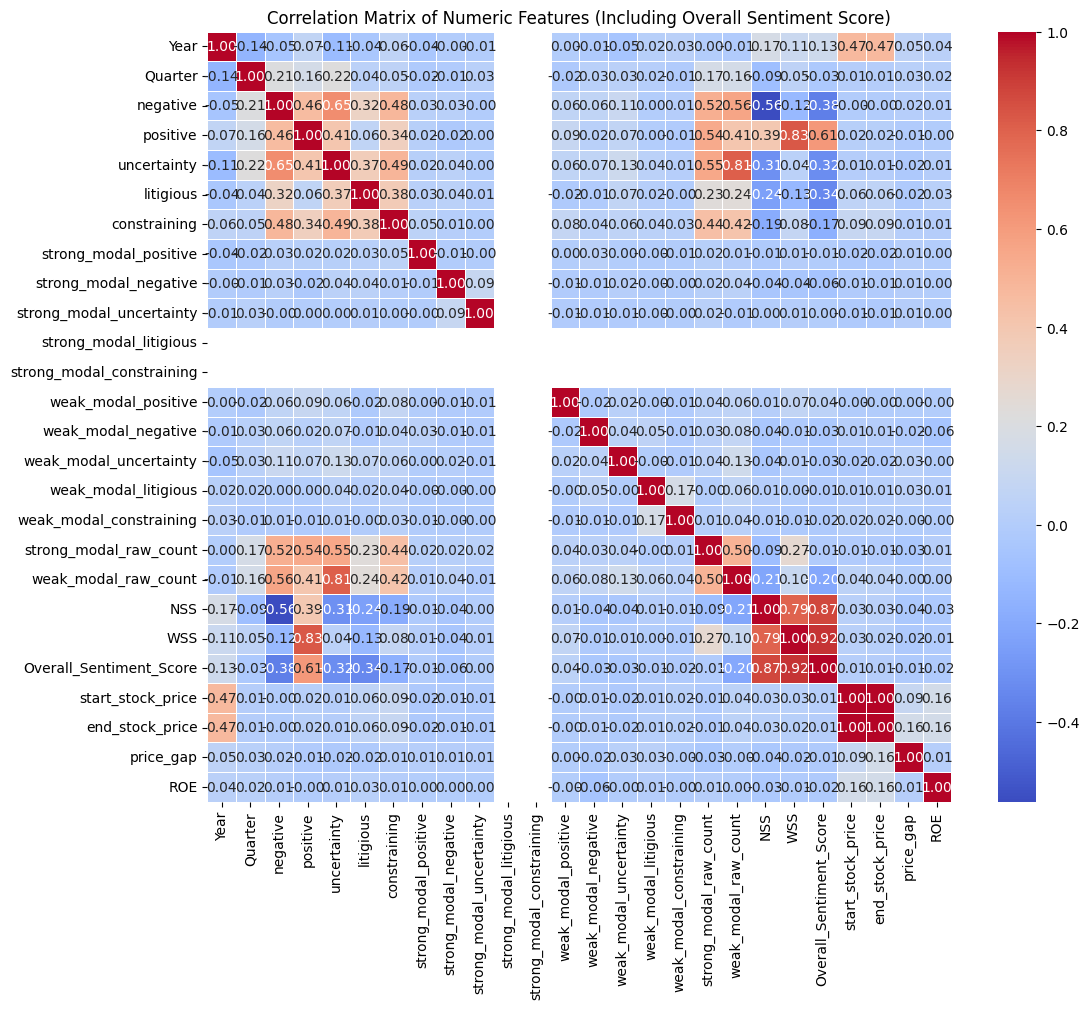

In [13]:
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features (Including Overall Sentiment Score)")
plt.show()


# Distribution of Numeric Features

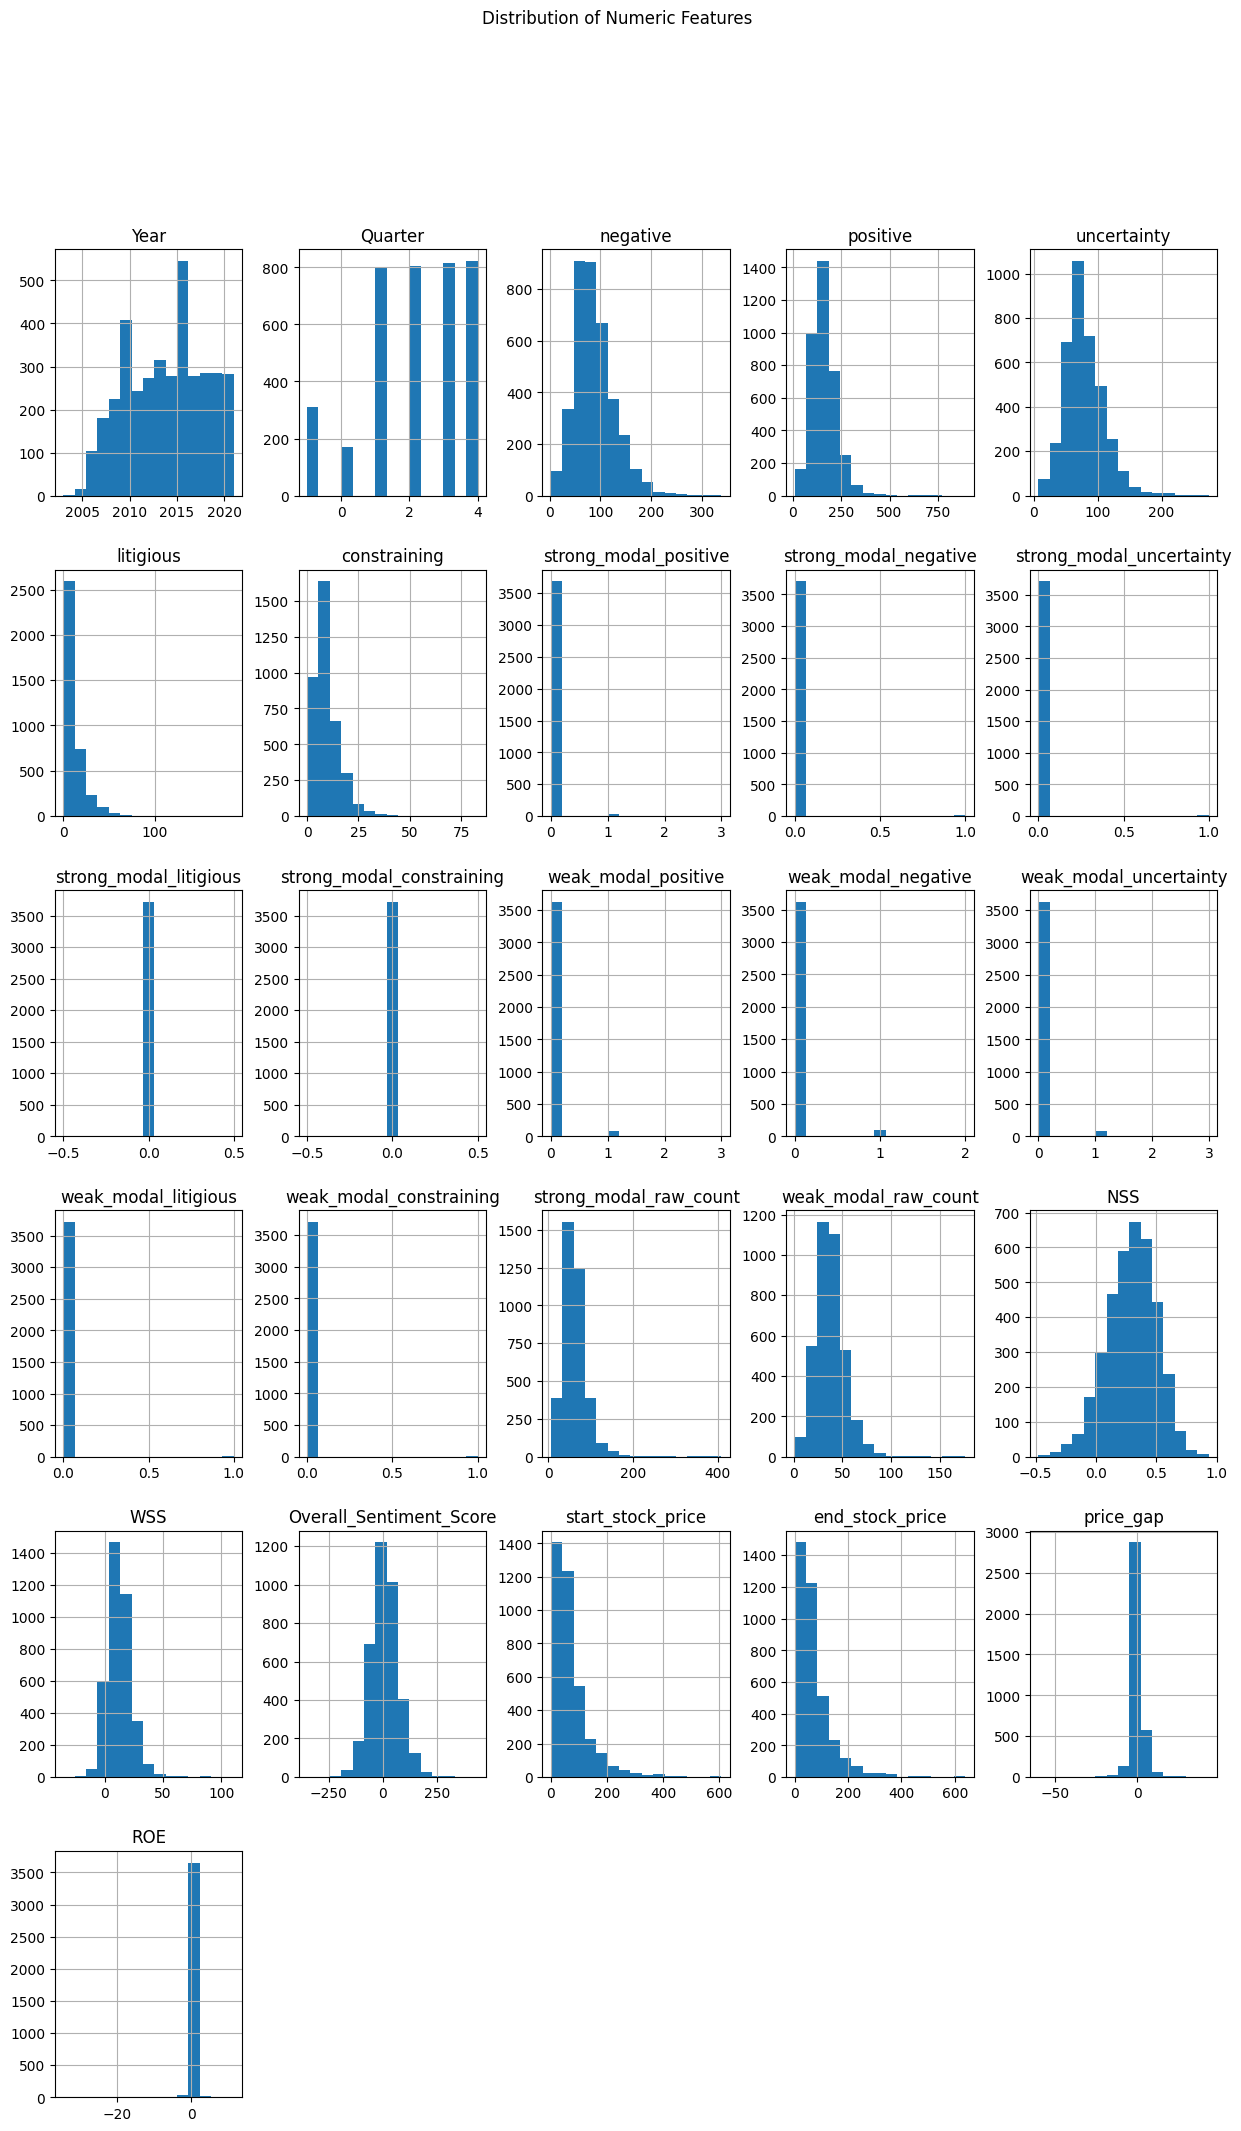

In [14]:
num_plots = len(numeric_cols)
ncols = 5
nrows = (num_plots // ncols) + (num_plots % ncols > 0)
df[numeric_cols].hist(bins=15, figsize=(15, nrows * 4), layout=(nrows, ncols))
plt.suptitle("Distribution of Numeric Features")
plt.show()


#  Box Plots for Outlier Detection in Numeric Features

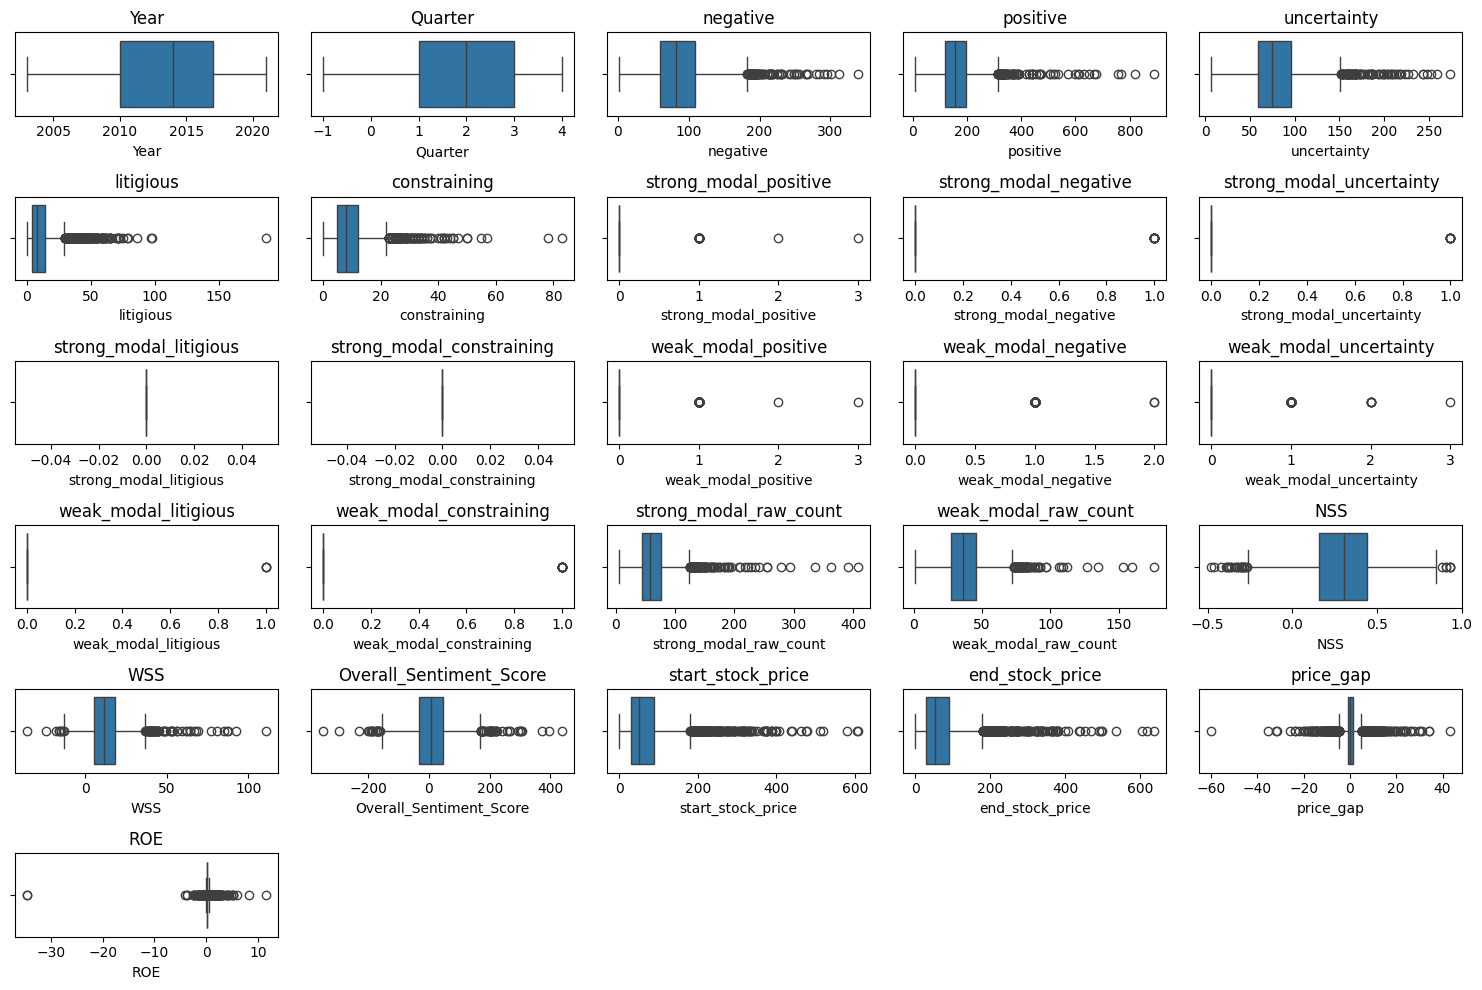

In [15]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


# Distribution of Sentiment Features

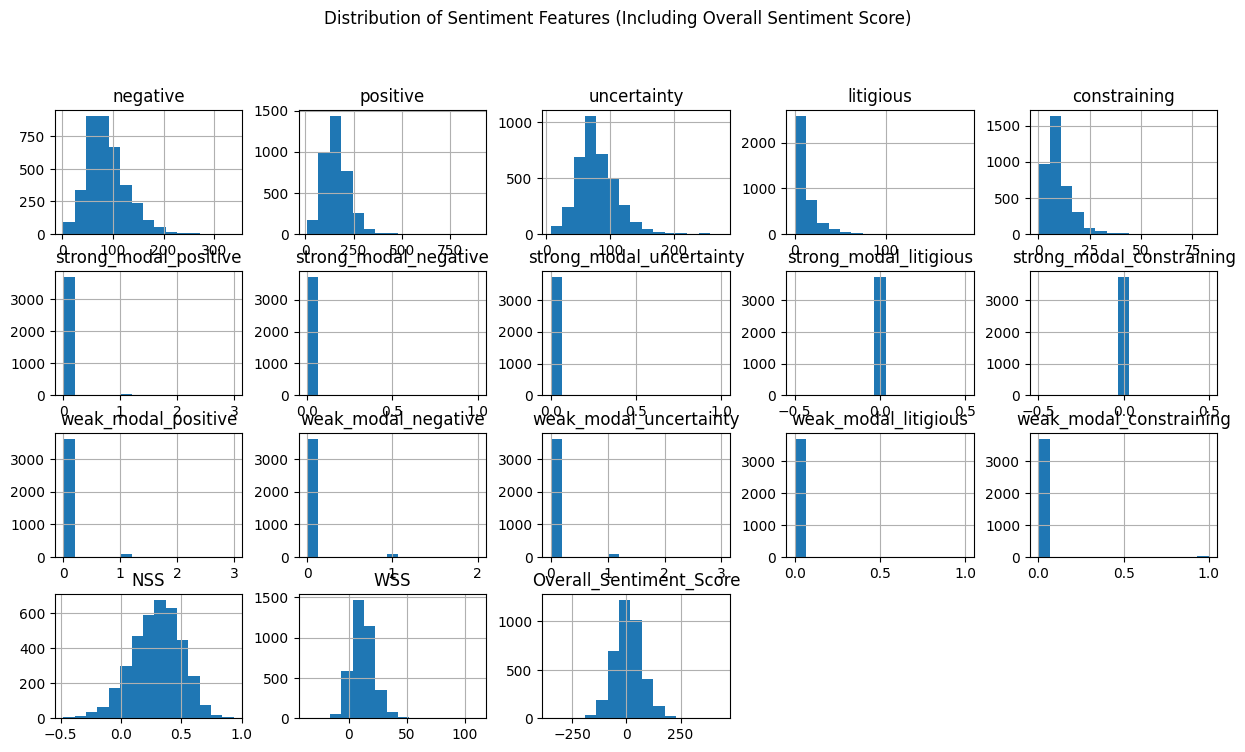

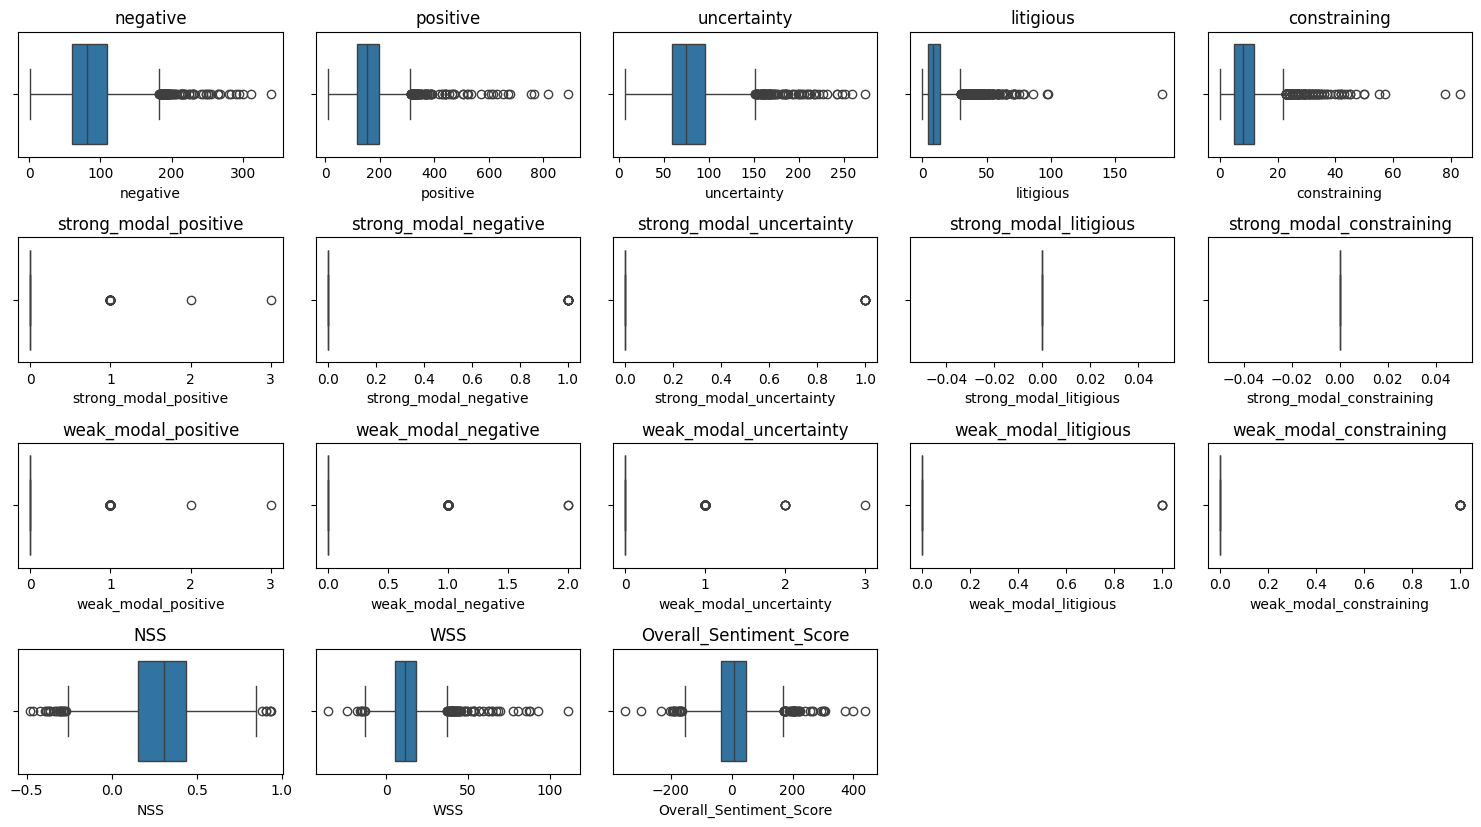

In [16]:
sentiment_cols = [
    'negative', 'positive', 'uncertainty', 'litigious', 'constraining', 
    'strong_modal_positive', 'strong_modal_negative', 'strong_modal_uncertainty', 
    'strong_modal_litigious', 'strong_modal_constraining', 'weak_modal_positive', 
    'weak_modal_negative', 'weak_modal_uncertainty', 'weak_modal_litigious', 
    'weak_modal_constraining', 'NSS', 'WSS', 'Overall_Sentiment_Score'
]
df[sentiment_cols].hist(bins=15, figsize=(15, 10), layout=(5, 5))
plt.suptitle("Distribution of Sentiment Features (Including Overall Sentiment Score)")
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(sentiment_cols, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


# Line Plot for Stock Price Trends

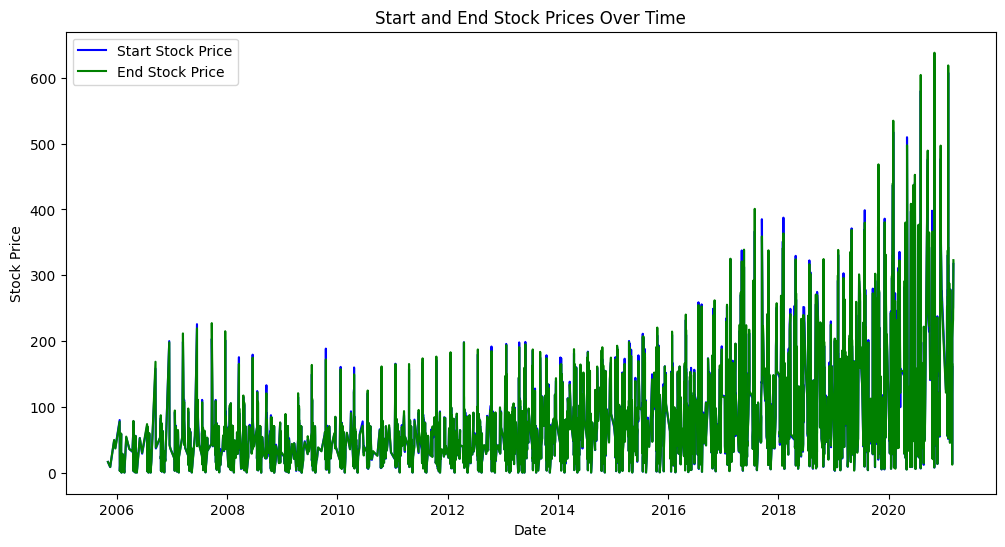

In [17]:
if 'Date' in df.columns and 'start_stock_price' in df.columns and 'end_stock_price' in df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['start_stock_price'], label='Start Stock Price', color='blue')
    plt.plot(df['Date'], df['end_stock_price'], label='End Stock Price', color='green')
    plt.fill_between(df['Date'], df['start_stock_price'], df['end_stock_price'], color='lightgreen', alpha=0.5)
    plt.title("Start and End Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


# Correlation Heatmap of Sentiment Features

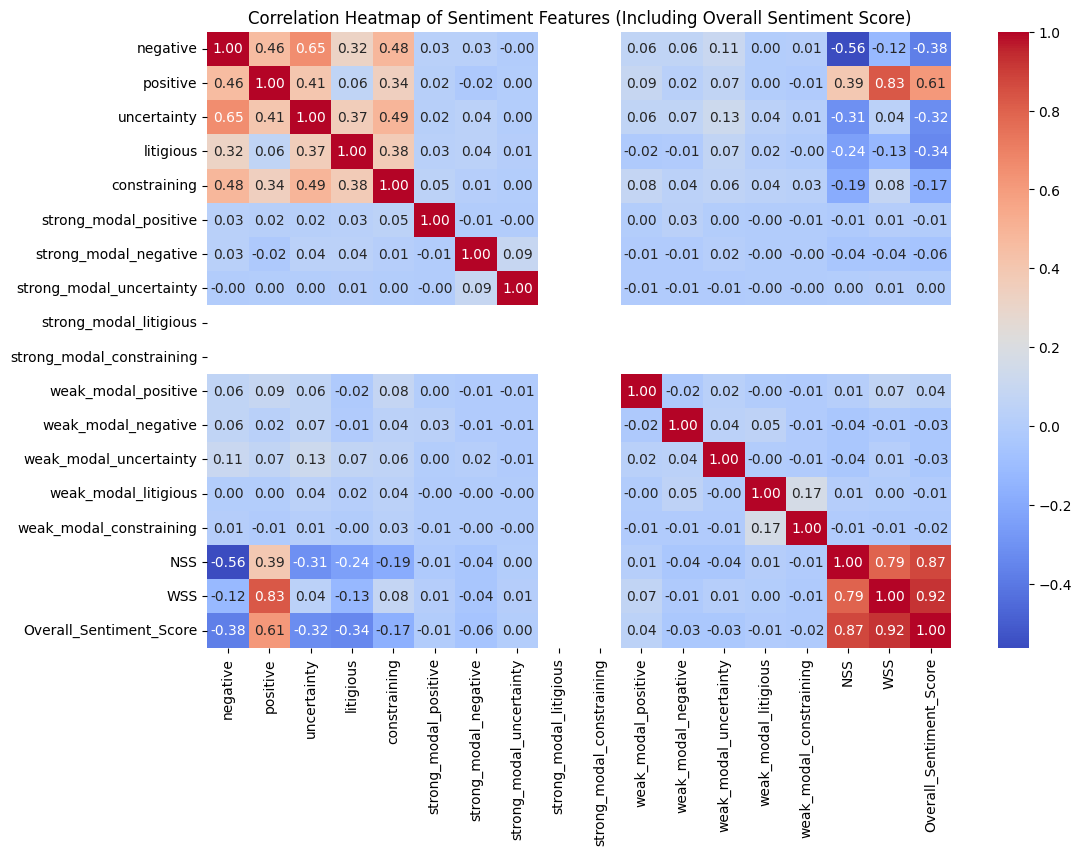

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[sentiment_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Sentiment Features (Including Overall Sentiment Score)")
plt.show()


#  Spider Chart (Radar Chart) for Multiple Metrics

In [19]:
if 'NSS' in df.columns and 'WSS' in df.columns and 'Overall_Sentiment_Score' in df.columns:
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=[df['NSS'].mean(), df['WSS'].mean(), df['positive'].mean(), df['negative'].mean(), df['Overall_Sentiment_Score'].mean()],
        theta=['NSS', 'WSS', 'Positive Sentiment', 'Negative Sentiment', 'Overall Sentiment Score'],
        fill='toself',
        name='Sentiment Scores'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True)
        ),
        showlegend=True,
        title="Spider Chart of Average Sentiment Metrics (Including Overall Sentiment Score)"
    )
    fig.show()


# Sentiment vs Stock Price Scatter Plot

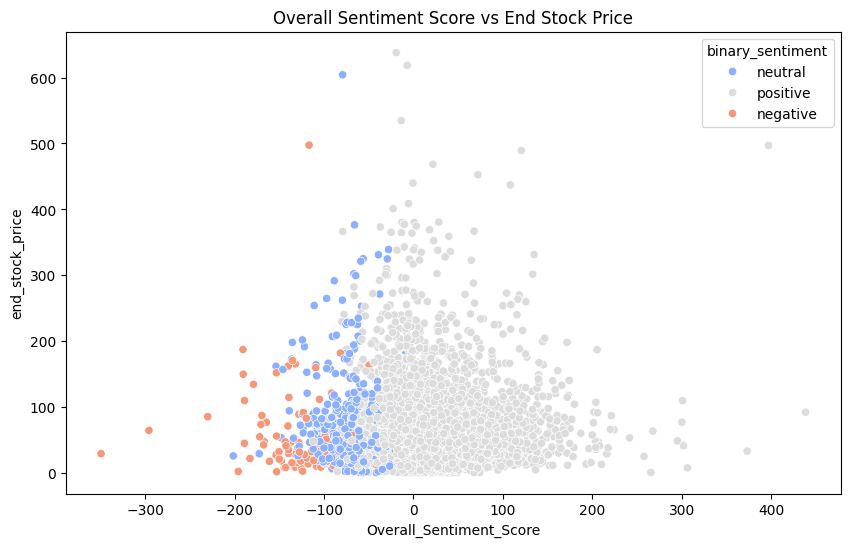

In [20]:
if 'end_stock_price' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Overall_Sentiment_Score', y='end_stock_price', data=df, hue='binary_sentiment', palette='coolwarm')
    plt.title("Overall Sentiment Score vs End Stock Price")
    plt.show()


# Box Plots for Sentiment Distribution Across Time

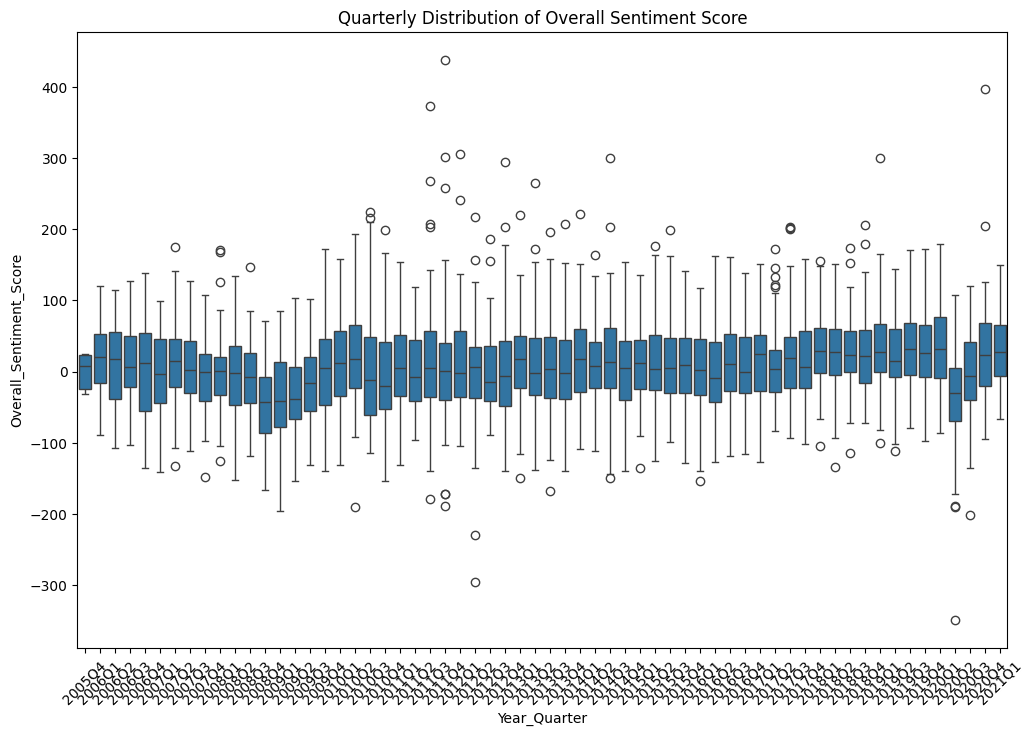

In [21]:
if 'Date' in df.columns:
    df['Year_Quarter'] = df['Date'].dt.to_period('Q')
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x='Year_Quarter', y='Overall_Sentiment_Score')
    plt.xticks(rotation=45)
    plt.title("Quarterly Distribution of Overall Sentiment Score")
    plt.show()


# Control Variables vs. Stock Price

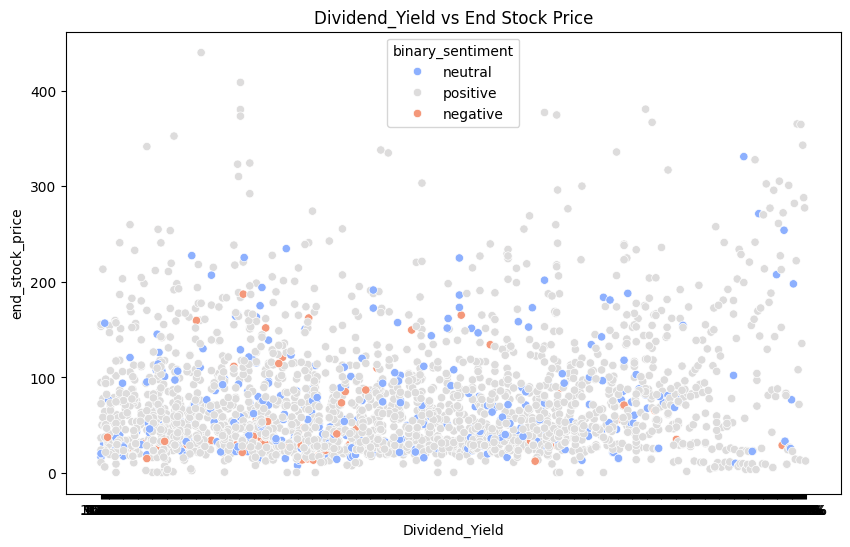

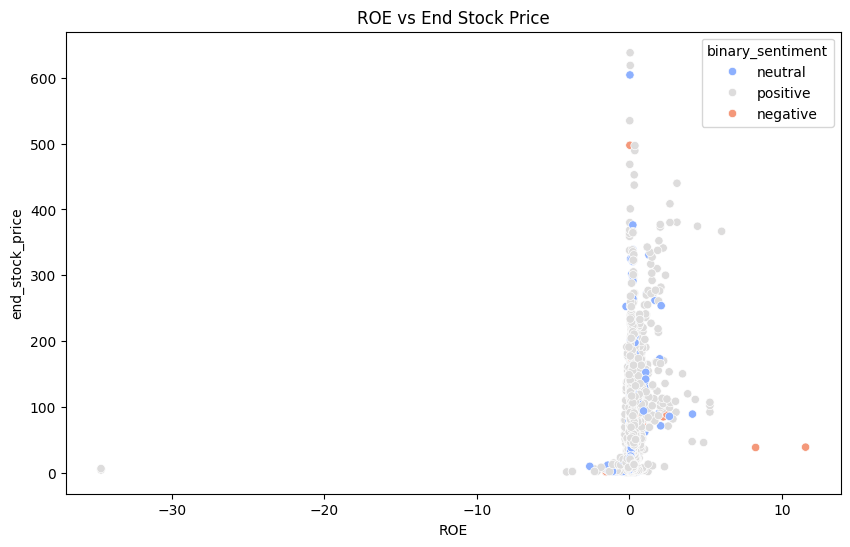

In [22]:
control_cols = ['Dividend_Yield', 'ROE']
if 'end_stock_price' in df.columns:
    for col in control_cols:
        if col in df.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=col, y='end_stock_price', data=df, hue='binary_sentiment', palette='coolwarm')
            plt.title(f"{col} vs End Stock Price")
            plt.show()





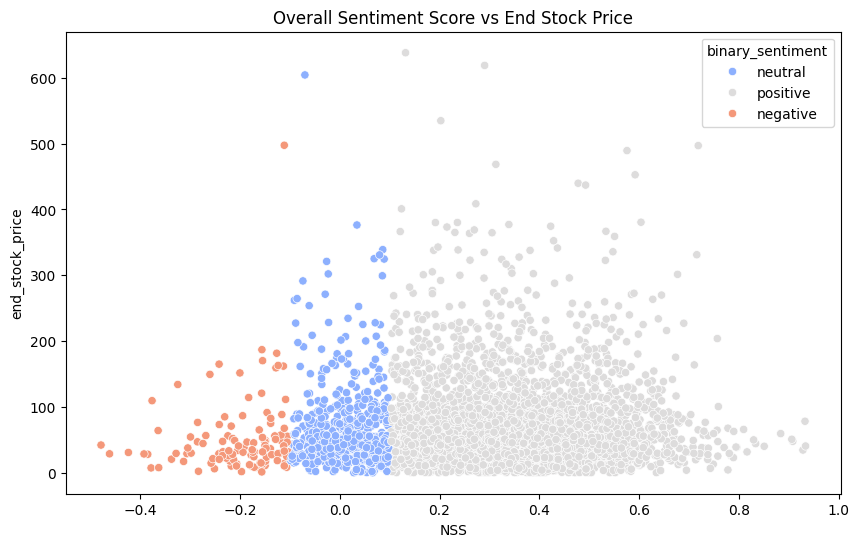

In [23]:
if 'end_stock_price' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='NSS', y='end_stock_price', data=df, hue='binary_sentiment', palette='coolwarm')
    plt.title("Overall Sentiment Score vs End Stock Price")
    plt.show()

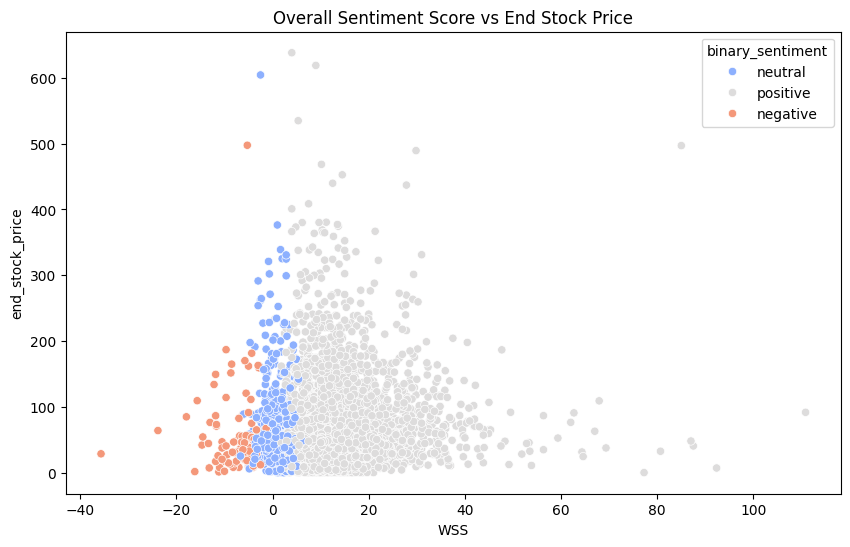

In [24]:
if 'end_stock_price' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='WSS', y='end_stock_price', data=df, hue='binary_sentiment', palette='coolwarm')
    plt.title("Overall Sentiment Score vs End Stock Price")
    plt.show()

# Import required libraries


# Step 1: Load and Clean Data

In [25]:
df = pd.read_csv('Anjula.csv')

# Remove percentage signs and convert to float
df['Dividend_Yield'] = df['Dividend_Yield'].str.replace('%', '').astype(float) / 100

# Convert specified columns to numeric
numeric_cols = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining',
                'strong_modal_positive', 'strong_modal_negative', 'strong_modal_uncertainty',
                'strong_modal_litigious', 'strong_modal_constraining', 'weak_modal_positive',
                'weak_modal_negative', 'weak_modal_uncertainty', 'weak_modal_litigious',
                'weak_modal_constraining', 'strong_modal_raw_count', 'weak_modal_raw_count',
                'NSS', 'WSS', 'Overall_Sentiment_Score', 'start_stock_price', 'end_stock_price', 'ROE']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(subset=['end_stock_price', 'NSS', 'WSS', 'Overall_Sentiment_Score', 'Dividend_Yield', 'ROE'], inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Step 2: Analyze Sentiment Effect on Stock Price (Without Control Variables)

# GLS Model 

In [26]:

X_sentiment = df[['NSS', 'WSS', 'Overall_Sentiment_Score']]
y = df['end_stock_price']
X_sentiment = sm.add_constant(X_sentiment)

# GLS Model for sentiment 
gls_model_sentiment = sm.GLS(y, X_sentiment).fit()
print("GLS Model Summary (Sentiment Only):")
print(gls_model_sentiment.summary())

GLS Model Summary (Sentiment Only):
                            GLS Regression Results                            
Dep. Variable:        end_stock_price   R-squared:                       0.004
Model:                            GLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.376
Date:                Sun, 10 Nov 2024   Prob (F-statistic):             0.0177
Time:                        14:27:54   Log-Likelihood:                -13195.
No. Observations:                2399   AIC:                         2.640e+04
Df Residuals:                    2395   BIC:                         2.642e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------


# Prediction and Visualization - GLS (Sentiment Only)

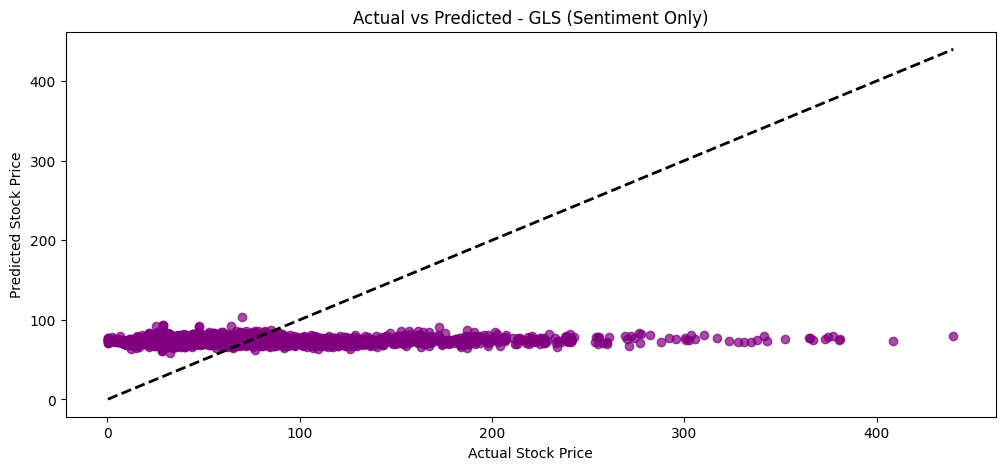

In [27]:
y_pred_gls_sentiment = gls_model_sentiment.predict(X_sentiment)
plt.figure(figsize=(12, 5))
plt.scatter(y, y_pred_gls_sentiment, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - GLS (Sentiment Only)")
plt.show()


# the relationship between each sentiment variable and stock price

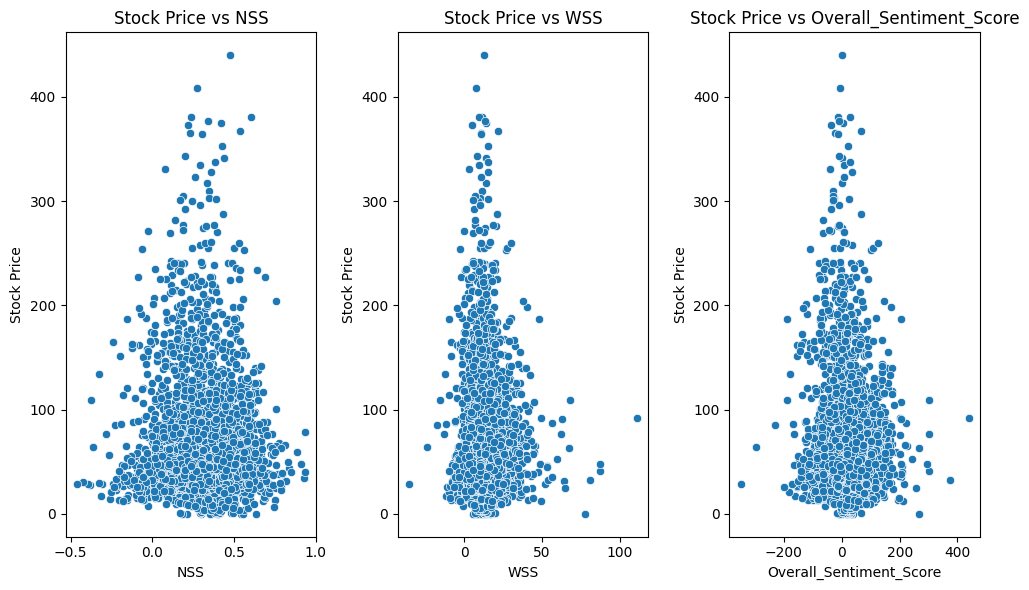

In [28]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(X_sentiment.columns[1:], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df[col], y=y)
    plt.title(f"Stock Price vs {col}")
    plt.xlabel(col)
    plt.ylabel("Stock Price")
plt.tight_layout()
plt.show()


# Step 3: Analyze Sentiment Effect on Stock Price with Control Variables

In [29]:
X_with_controls = df[['NSS', 'WSS', 'Overall_Sentiment_Score', 'Dividend_Yield', 'ROE']]
X_with_controls = sm.add_constant(X_with_controls)

# GLS Model for sentiment with control variables
gls_model_with_controls = sm.GLS(y, X_with_controls).fit()
print("\nGLS Model Summary (With Control Variables):")
print(gls_model_with_controls.summary())


GLS Model Summary (With Control Variables):
                            GLS Regression Results                            
Dep. Variable:        end_stock_price   R-squared:                       0.164
Model:                            GLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     93.86
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           1.84e-90
Time:                        14:27:54   Log-Likelihood:                -12986.
No. Observations:                2399   AIC:                         2.598e+04
Df Residuals:                    2393   BIC:                         2.602e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------


# Prediction and Visualization - GLS with Controls

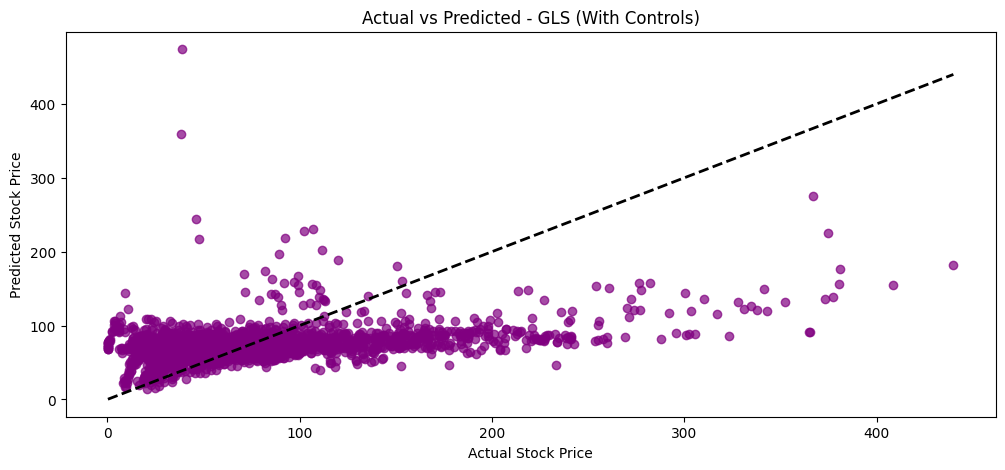

In [30]:
y_pred_gls_with_controls = gls_model_with_controls.predict(X_with_controls)
plt.figure(figsize=(12, 5))
plt.scatter(y, y_pred_gls_with_controls, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - GLS (With Controls)")
plt.show()

# Comparison

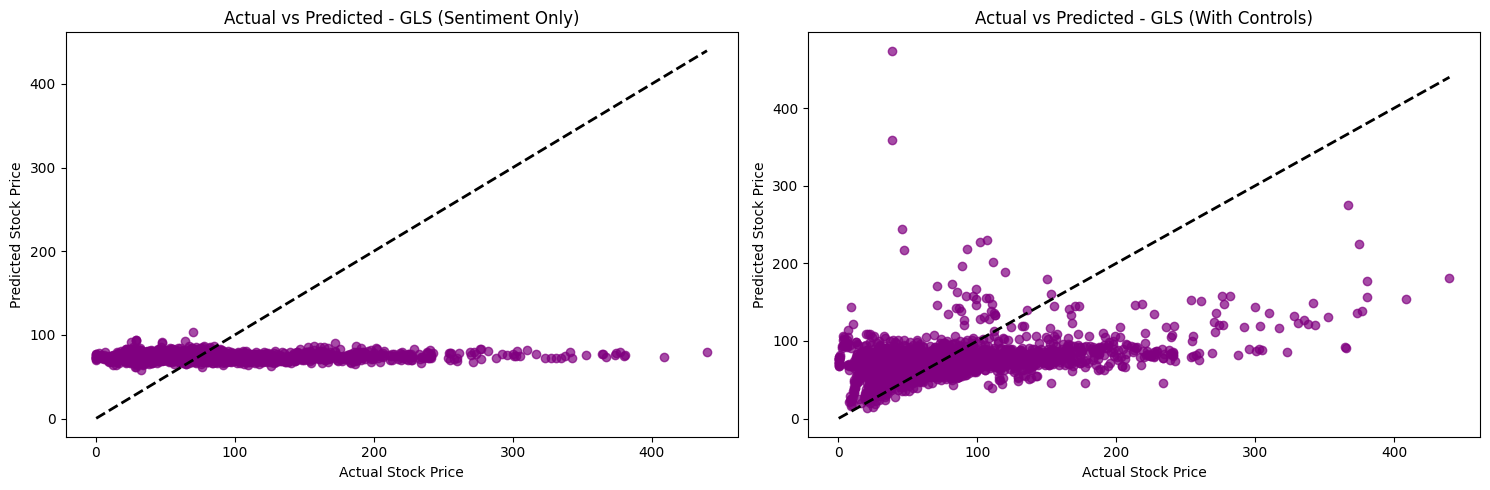

In [31]:
plt.figure(figsize=(15, 5))

# GLS (Sentiment Only)
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_gls_sentiment, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - GLS (Sentiment Only)")

# GLS (With Controls)
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_gls_with_controls, alpha=0.7, color="purple")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - GLS (With Controls)")

plt.tight_layout()
plt.show()

# Additional regression models

# Linear Regression Model (Without Control Variables)

In [32]:
lin_reg_model_no_controls = LinearRegression()
lin_reg_model_no_controls.fit(X_sentiment, y)  
print("\nLinear Regression Model (No Controls):")
print("Coefficients:", lin_reg_model_no_controls.coef_)
print("Intercept:", lin_reg_model_no_controls.intercept_)
print("R^2 Score:", lin_reg_model_no_controls.score(X_sentiment, y))

y_pred_lin_reg_no_controls = lin_reg_model_no_controls.predict(X_sentiment)


Linear Regression Model (No Controls):
Coefficients: [ 0.         21.34681787  0.62095549 -0.17969191]
Intercept: 61.7579583901582
R^2 Score: 0.004211386615682433



# Ridge and PLS Regression (Without Control Variables)

In [33]:
scaler_no_controls = StandardScaler()
X_scaled_sentiment = scaler_no_controls.fit_transform(X_sentiment)  
X_train, X_test, y_train, y_test = train_test_split(X_scaled_sentiment, y, test_size=0.2, random_state=42)

# Ridge Regression (Without Control Variables)
ridge_model_no_controls = Ridge(alpha=1.0)
ridge_model_no_controls.fit(X_train, y_train)
print("\nRidge Regression (No Controls):")
print("Coefficients:", ridge_model_no_controls.coef_)
print("R^2 Score (Test Set):", ridge_model_no_controls.score(X_test, y_test))

y_pred_ridge_no_controls = ridge_model_no_controls.predict(X_test)

# PLS Regression (Without Control Variables)
pls_model_no_controls = PLSRegression(n_components=3)
pls_model_no_controls.fit(X_train, y_train)
print("\nPLS Regression (No Controls):")
print("Coefficients:", pls_model_no_controls.coef_)
print("R^2 Score (Test Set):", pls_model_no_controls.score(X_test, y_test))

y_pred_pls_no_controls = pls_model_no_controls.predict(X_test)


Ridge Regression (No Controls):
Coefficients: [  0.           3.41648761   6.29768221 -11.76356522]
R^2 Score (Test Set): -0.0020281394912766704

PLS Regression (No Controls):
Coefficients: [[  0.           3.45412959   6.36728728 -11.86659056]]
R^2 Score (Test Set): -0.0020075398612946493



# Quantile Regression (Without Control Variables)

In [34]:
quant_reg_model_no_controls = quantreg('end_stock_price ~ NSS + WSS + Overall_Sentiment_Score', data=df)  
quant_reg_results_no_controls = quant_reg_model_no_controls.fit(q=0.5)
print("\nQuantile Regression Summary (0.5 Quantile) (No Controls):")
print(quant_reg_results_no_controls.summary())

y_pred_quant_reg_no_controls = quant_reg_results_no_controls.predict(df)


Quantile Regression Summary (0.5 Quantile) (No Controls):
                         QuantReg Regression Results                          
Dep. Variable:        end_stock_price   Pseudo R-squared:             0.003792
Model:                       QuantReg   Bandwidth:                       17.05
Method:                 Least Squares   Sparsity:                        99.61
Date:                Sun, 10 Nov 2024   No. Observations:                 2399
Time:                        14:27:55   Df Residuals:                     2395
                                        Df Model:                            3
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  44.8764      4.367     10.277      0.000      36.313      53.439
NSS                         2.7756     10.356      0.268      0.789     -17.532      23.084
WSS                 


# Plotting Actual vs Predicted for each model

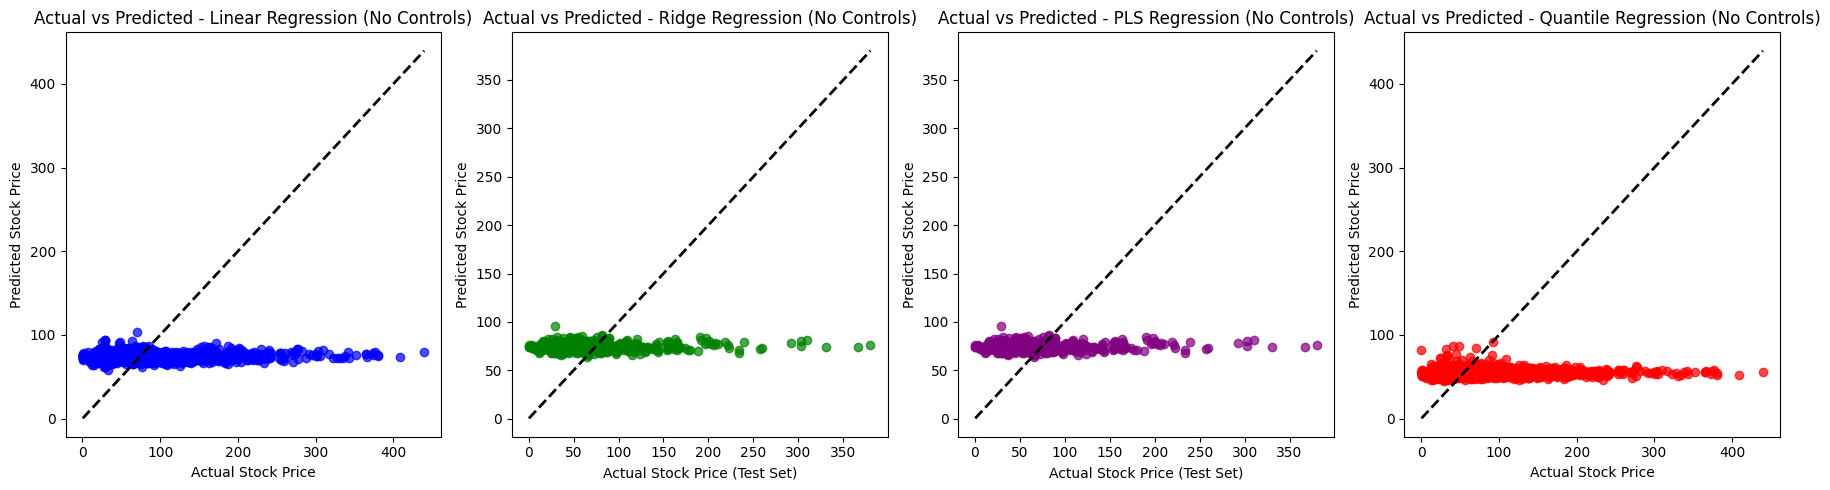

In [35]:
plt.figure(figsize=(18, 5))

# Linear Regression (No Controls)
plt.subplot(1, 4, 1)
plt.scatter(y, y_pred_lin_reg_no_controls, alpha=0.7, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Linear Regression (No Controls)")

# Ridge Regression (No Controls)
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_ridge_no_controls, alpha=0.7, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price (Test Set)")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Ridge Regression (No Controls)")

# PLS Regression (No Controls)
plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_pls_no_controls, alpha=0.7, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price (Test Set)")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - PLS Regression (No Controls)")

# Quantile Regression (No Controls)
plt.subplot(1, 4, 4)
plt.scatter(y, y_pred_quant_reg_no_controls, alpha=0.7, color="red")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Quantile Regression (No Controls)")

plt.tight_layout()
plt.show()


# Linear Regression Model ( with controls )

In [36]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_with_controls, y)
print("\nLinear Regression Model:")
print("Coefficients:", lin_reg_model.coef_)
print("Intercept:", lin_reg_model.intercept_)
print("R^2 Score:", lin_reg_model.score(X_with_controls, y))


Linear Regression Model:
Coefficients: [ 0.00000000e+00  3.12208756e+01  6.52112526e-01 -2.00095476e-01
 -9.35113612e+02  3.45806723e+01]
Intercept: 71.30195121742464
R^2 Score: 0.1639576860147549



# Ridge and PLS Regression ( with controls )

In [37]:
scaler = StandardScaler()
X_scaled_controls = scaler.fit_transform(X_with_controls)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_controls, y, test_size=0.2, random_state=42)

# Ridge Regression ( with controls ) 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
print("\nRidge Regression:")
print("Coefficients:", ridge_model.coef_)
print("R^2 Score (Test Set):", ridge_model.score(X_test, y_test))

# PLS Regression ( with controls )
pls_model = PLSRegression(n_components=3)
pls_model.fit(X_train, y_train)
print("\nPLS Regression:")
print("Coefficients:", pls_model.coef_)
print("R^2 Score (Test Set):", pls_model.score(X_test, y_test))


Ridge Regression:
Coefficients: [  0.           5.06331176   7.04013334 -13.16407675 -13.59846551
  22.30590411]
R^2 Score (Test Set): 0.09006438408716777

PLS Regression:
Coefficients: [[  0.           3.43293782   1.91539877  -6.67524299 -12.41719574
   23.20192173]]
R^2 Score (Test Set): 0.08026083111806348



# Quantile Regression ( with controls )

In [38]:
quant_reg_model = quantreg('end_stock_price ~ NSS + WSS + Overall_Sentiment_Score + Dividend_Yield + ROE', data=df)
quant_reg_results = quant_reg_model.fit(q=0.5)
print("\nQuantile Regression Summary (0.5 Quantile):")
print(quant_reg_results.summary())


Quantile Regression Summary (0.5 Quantile):
                         QuantReg Regression Results                          
Dep. Variable:        end_stock_price   Pseudo R-squared:              0.09171
Model:                       QuantReg   Bandwidth:                       14.43
Method:                 Least Squares   Sparsity:                        82.21
Date:                Sun, 10 Nov 2024   No. Observations:                 2399
Time:                        14:27:55   Df Residuals:                     2393
                                        Df Model:                            5
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  54.8278      3.950     13.879      0.000      47.081      62.574
NSS                        14.9877      8.557      1.752      0.080      -1.792      31.767
WSS                         0.5868


# Model Comparison - Actual vs Predicted for Each Model

In [39]:
y_pred_lin_reg = lin_reg_model.predict(X_with_controls)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_pls = pls_model.predict(X_test) 
y_pred_quant_reg = quant_reg_results.predict(df)


# Plot for Linear Regression, Ridge, PLS, and Quantile Regression

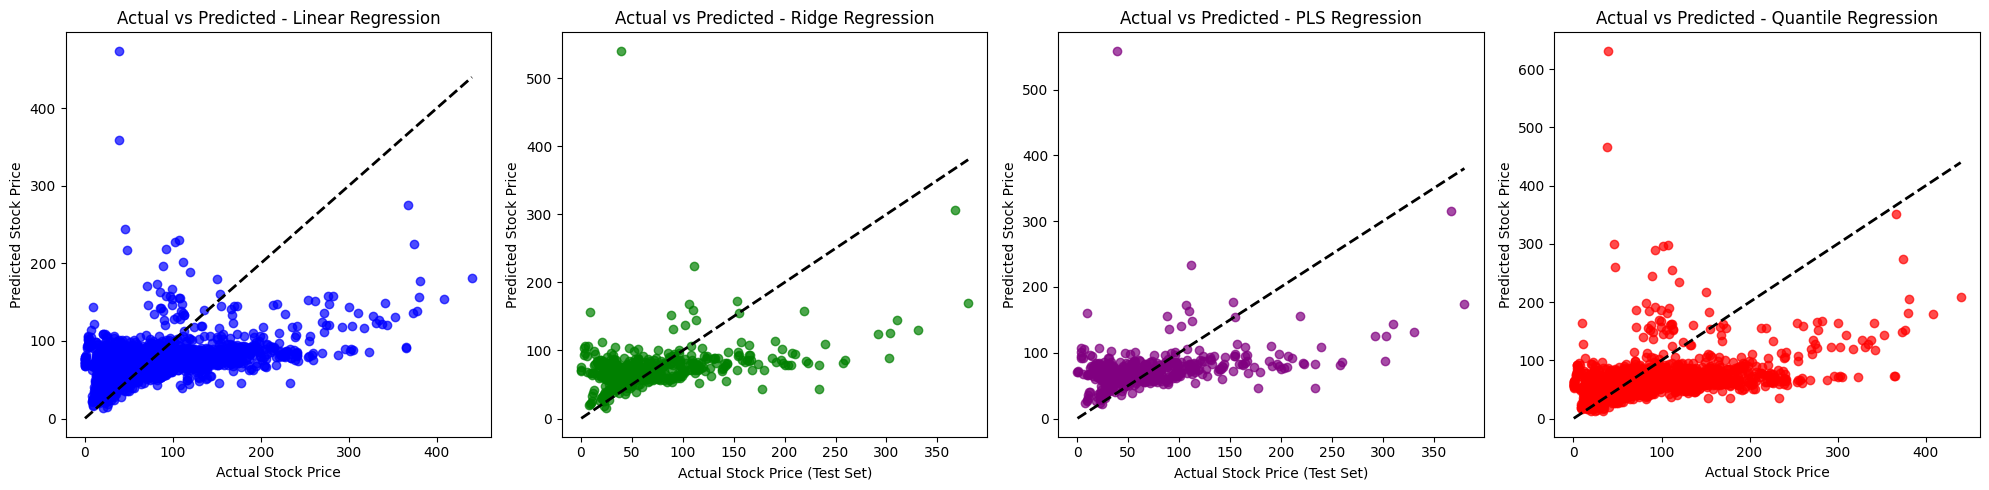

In [40]:
plt.figure(figsize=(20, 5))

# Linear Regression
plt.subplot(1, 4, 1)
plt.scatter(y, y_pred_lin_reg, alpha=0.7, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Linear Regression")

# Ridge Regression
plt.subplot(1, 4, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.7, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price (Test Set)")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Ridge Regression")

# PLS Regression
plt.subplot(1, 4, 3)
plt.scatter(y_test, y_pred_pls, alpha=0.7, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price (Test Set)")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - PLS Regression")

# Quantile Regression
plt.subplot(1, 4, 4)
plt.scatter(y, y_pred_quant_reg, alpha=0.7, color="red")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Stock Price")
plt.ylabel("Predicted Stock Price")
plt.title("Actual vs Predicted - Quantile Regression")

plt.tight_layout()
plt.show()


